# Test CNN_Virus code and refactor

Original code is the github repo [here](https://github.com/MaHaoran627/CNN_Virus)

In [1]:
import numpy as np
import sys
from pathlib import Path


%load_ext autoreload
%autoreload 2

Added following path: /home/vtec/projects/metagenomics/src


Setup for local or colab notebook

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    print('Running in colab')
    # mount gdrive
    # clone metagenomics repo
    # set path to source
    p2source = Path('')
    # set paths to data

    pass
else:
    print('Running locally')
    # set path to source
    p2source = Path('../src').resolve().absolute()
    # set paths to data
    data = Path('../data/cnn_virus').resolve()
    assert data.is_dir()

if p2source.is_dir():
    sys.path.insert(1, str(p2source))
    print(f"Added following path: {p2source}")
else:
    print(f"There is no directory {p2source}")

# Preprocessing data

In [3]:
from preprocessing import get_learning_weights, get_params_50mer, get_kmer_from_50mer
from preprocessing import DataGenerator_from_50mer

from architecture import build_model

In [19]:
p2file = Path('../data/cnn_virus/50mer_validating').resolve()
f_matrix, f_labels, f_pos = get_kmer_from_50mer(p2file, max_seqs==1000)
len(f_matrix), len(f_labels), len(f_pos)

NameError: name 'max_seqs' is not defined

In [5]:
i = 0
f_matrix[i], f_labels[i], f_pos[i]

('AAAAAGATTTTGAGAGAGGTCGACCTGTCCTCCTAAAACGTTTACAAAAG', '71', '0')

In [6]:
#path for the training file
filepath_train= data /"50mer_training"
#path for the validating file
filepath_val= data / "50mer_validating"
#path for the learning weights file
filepath_weights=data / "weights_of_classes"


#paths for saving model and loss
filepath_saved=Path("../saved/cnn_virus").resolve()


In [7]:
d_nucl={"A":0,"C":1,"G":2,"T":3,"N":4}
f_matrix,f_labels,f_pos=get_kmer_from_50mer(filepath_train, max_seqs=10000)
f_matrix_val,f_labels_val,f_pos_val=get_kmer_from_50mer(filepath_val)

params = get_params_50mer()
d_weights=get_learning_weights(filepath_weights)

training_generator = DataGenerator_from_50mer(f_matrix, f_labels, f_pos, **params)
val_generator = DataGenerator_from_50mer(f_matrix_val, f_labels_val, f_pos_val, **params)

In [8]:
len(training_generator)

10

[`tf.keras.utils.Sequence`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence)

In [9]:
tg = training_generator.__getitem__(0)

In [10]:
len(tg), type(tg), type(tg[0]), type(tg[1])

(2, tuple, numpy.ndarray, dict)

In [11]:
inp, out_d = tg
out_d.keys()

dict_keys(['output1', 'output2'])

In [12]:
inp.shape, out_d['output1'].shape, out_d['output2'].shape

((1024, 50, 5), (1024, 187), (1024, 10))

In [13]:
inp[:2, :4, :]

array([[[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.]]])

In [14]:
out1 = out_d['output1']
out2 = out_d['output2']

out1[:2, :10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

# Build model and review it

In [15]:
model=build_model()
model.summary()

Creating Model


2022-08-30 17:57:41.629408: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-30 17:57:41.632524: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 5)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 50, 512)      13312       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 50, 512)     2048        ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 25, 512)      0           ['batch_normalization[0][0]']

In [16]:
model.compile(optimizer='adam',
	loss={'output1':'categorical_crossentropy','output2':'categorical_crossentropy'},
	metrics=['accuracy'])

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

result = model.fit(
    training_generator,
	epochs=2,
	verbose=1,
	# class_weight=d_weights,
	validation_data=val_generator,
	callbacks=[es]
	)


Epoch 1/2
10/10 [==============================] - 3025s 334s/step - loss: 9.5860 - output1_loss: 6.0184 - output2_loss: 3.5676 - output1_accuracy: 0.0544 - output2_accuracy: 0.1035 - val_loss: 9.0850 - val_output1_loss: 5.8918 - val_output2_loss: 3.1932 - val_output1_accuracy: 0.0654 - val_output2_accuracy: 0.0986
Epoch 2/2
10/10 [==============================] - 2858s 310s/step - loss: 6.3438 - output1_loss: 3.9900 - output2_loss: 2.3538 - output1_accuracy: 0.1749 - output2_accuracy: 0.1678 - val_loss: 7.2590 - val_output1_loss: 4.7143 - val_output2_loss: 2.5446 - val_output1_accuracy: 0.0944 - val_output2_accuracy: 0.1040


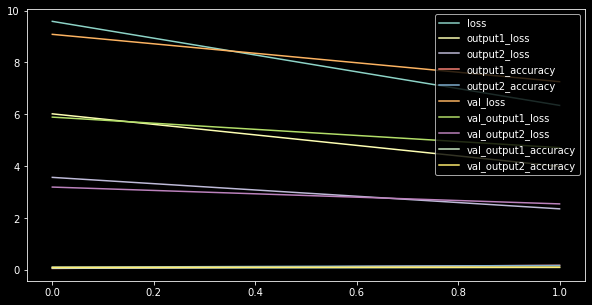

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
_, ax = plt.subplots(figsize=(10,5))
pd.DataFrame(result.history).plot(ax=ax)
ax.legend(loc='upper right');